<a href="https://colab.research.google.com/github/Brian0718UOA/2021-Summer-Research-Scholarship/blob/main/bk_yolov5_NZTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


1. setup
2. import nzta camera images from url
3. crop the imported images
4. inference the cropped images
5. count number of vehicles from inferenced results

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# change directory to yolov5 folder
%cd drive/MyDrive/Colab \Notebooks/yolov5

/content/drive/MyDrive/Colab Notebooks/yolov5


In [ ]:
# do not need to clone (i.e run this cell) if yolov5 folder is uploaded to Google Colab
# !git clone https://github.com/ultralytics/yolov5.git
# %cd yolov5/
# !pip install -U -r requirements.txt

# Upload files from URL

In [3]:
# reading url from csv file
import pandas as pd
import requests
import os
from datetime import datetime


# create new folder to save images read from URL
# this folder will disappear when google colab disconnects as
# it is not saved to google drive
newfolder = r'/content/raw_images'  
os.makedirs(newfolder)

url_df = pd.read_csv("Traffic-state-cctv/Brian SRS - NZTA traffic camera.csv", header=None)  # change directory
url_df.columns = ['location','url']
url_df

timestamp = []

for url in url_df.url:
  dateTimeObj = datetime.now()  # get current date and timestamp

  response = requests.get(url, stream = True)

  jpg_file = open('/content/raw_images/'+str(url[-7:-4])+'.jpg', 'wb')  # change path to raw_images folder created from cell above  
  for chunk in response.iter_content(chunk_size = 1024):
    jpg_file.write(chunk)
  jpg_file.close()  

  date = str(dateTimeObj)+"_"+str(url[-7:-4])+"_"
  timestamp.append(date)

print(timestamp)
  

['2022-02-07 00:25:40.129223_714_', '2022-02-07 00:25:41.797536_653_', '2022-02-07 00:25:43.006650_654_', '2022-02-07 00:25:44.402875_655_', '2022-02-07 00:25:45.209902_651_', '2022-02-07 00:25:46.678623_723_', '2022-02-07 00:25:47.682408_686_', '2022-02-07 00:25:48.685736_687_', '2022-02-07 00:25:49.691759_688_', '2022-02-07 00:25:50.498778_689_', '2022-02-07 00:25:51.974204_697_', '2022-02-07 00:25:52.978348_130_', '2022-02-07 00:25:54.968863_140_', '2022-02-07 00:25:55.772565_150_', '2022-02-07 00:25:57.457083_160_', '2022-02-07 00:26:01.553240_170_', '2022-02-07 00:26:03.025239_270_', '2022-02-07 00:26:04.188297_271_', '2022-02-07 00:26:05.983443_171_', '2022-02-07 00:26:06.985630_172_', '2022-02-07 00:26:07.988483_173_', '2022-02-07 00:26:09.467436_174_', '2022-02-07 00:26:10.471289_175_', '2022-02-07 00:26:11.498051_176_', '2022-02-07 00:26:12.708832_177_', '2022-02-07 00:26:13.927109_178_', '2022-02-07 00:26:15.578543_/70_', '2022-02-07 00:26:16.779360_221_', '2022-02-07 00:26:1

# ROI

In [4]:
def crop_image(y1,y2,x1,x2,filename):
  image = cv2.imread(dir_read+filename+extension)
  image = image[y1:y2, x1:x2]
  cv2.imwrite(dir_save+"c"+filename+extension, image)
  print(f"cropped {filename+extension} saved to {dir_save}")

import os
import cv2
import numpy as np

# create new folder to save cropped images 
newfolder = r'/content/cropped_images'
if os.path.exists(newfolder) == True:
  print("folder already exists")
else:
  os.makedirs(newfolder)

dir_read = "/content/raw_images/"  # read images from raw_images folder
dir_save = "/content/cropped_images/"  # save images to cropped_images folder
extension = ".jpg"

In [5]:
# crop NZTA CCTV
crop_image(314, 562, 0, 548, filename='653')
crop_image(173, 576, 0, 1024, filename="654")
crop_image(145, 360, 70, 495, filename="714")
crop_image(170, 288, 270, 352, filename="655")
crop_image(246, 443, 69, 479, filename="651")
crop_image(188, 270, 118, 443, filename="723")
crop_image(166, 270, 122, 296, filename="686")
crop_image(110, 200, 186, 370, filename="687")
crop_image(145, 270, 195, 480, filename="688")
crop_image(143, 270, 100, 340, filename="689")
crop_image(195, 360, 70, 640, filename="20")
crop_image(180, 260, 180, 327, filename="30")
crop_image(137, 285, 22, 240, filename="40")
crop_image(208, 360, 364, 624, filename="50")
crop_image(160, 270, 0, 210, filename="60")
crop_image(166, 312, 400, 640, filename="70")
crop_image(165, 288, 46, 384, filename="80")
crop_image(130, 252, 0, 198, filename="90")
crop_image(170, 234, 0, 248, filename="100")
crop_image(397, 720, 365, 1280, filename="110")
crop_image(400, 1080, 573, 1279, filename="120")
crop_image(108, 240, 140, 306, filename="121")
crop_image(154, 285, 80, 275, filename="122")
crop_image(80, 171, 138, 260, filename="123")
crop_image(112, 280, 100, 370, filename="124")
crop_image(140, 360, 150, 387, filename="125")
crop_image(470, 1080, 591, 1150, filename="126")
crop_image(765, 1075, 928, 1656, filename="130")
crop_image(155, 286, 54, 254, filename="140")
crop_image(130, 325, 0, 360, filename="150")
crop_image(190, 360, 76, 467, filename="160")
crop_image(155, 270, 75, 220, filename="170")
crop_image(167, 270, 12, 280, filename="171")
crop_image(105, 195, 500, 639, filename="172")
crop_image(105, 270, 113, 260, filename="173")
crop_image(110, 215, 0, 141, filename="174")
crop_image(128, 270, 258, 381, filename="175")
crop_image(134, 360, 297, 514, filename="176")
crop_image(179, 360, 239, 375, filename="177")
crop_image(135, 269, 190, 342, filename="178")
# crop_image(94, 270, 0, 480, filename="190") # roundabout intersection
crop_image(115, 270, 165, 390, filename="191")
crop_image(130, 245, 94, 247, filename="192")
crop_image(140, 270, 166, 480, filename="193")
crop_image(180, 360, 86, 419, filename="194")
crop_image(164, 270, 172, 360, filename="201")
crop_image(125, 270, 153, 390, filename="202")
crop_image(175, 270, 113, 300, filename="203")
crop_image(135, 270, 40, 280, filename="204")
crop_image(535, 1010, 0, 893, filename="205")
# crop_image(155, 270, 109, 480, filename="206") # intersection
# crop_image(106, 270, 0, 480, filename="207") # intersection
crop_image(120, 270, 140, 300, filename="208")
crop_image(140, 360, 0, 456, filename="209")
crop_image(117, 270, 220, 440, filename="210")
crop_image(171, 360, 143, 640, filename="211")
crop_image(158, 360, 170, 437, filename="212")
crop_image(175, 360, 192, 590, filename="214")
crop_image(555, 807, 80, 571, filename="215")
crop_image(157, 360, 193, 400, filename="221")
crop_image(190, 360, 160, 360, filename="222")
# crop_image(68, 270, 87, 480, filename="223") # roundabout
crop_image(160, 360, 202, 408, filename="224")
crop_image(353, 800, 902, 1492, filename="225")
crop_image(170, 400, 376, 661, filename="226")
crop_image(128, 380, 48, 368, filename="227")
crop_image(150, 380, 190, 508, filename="228")
crop_image(134, 270, 205, 480, filename="230")
crop_image(196, 314, 431, 523, filename="232")
crop_image(60, 220, 26, 240, filename="233")
crop_image(116, 204, 256, 352, filename="234")
# crop_image(filename="236") # unavailable
crop_image(46, 288, 162, 352, filename="237")
# crop_image(108, 287, 15, 250, filename="238") # black cam
crop_image(60, 288, 0, 352, filename="245")
# crop_image(82, 288, 0, 273, filename="246") # intersection
crop_image(90, 236, 80, 225, filename="247")
crop_image(95, 288, 18, 220, filename="249")
crop_image(107, 280, 0, 299, filename="250")
crop_image(158, 230, 111, 275, filename="251")
crop_image(86, 288, 86, 266, filename="252")
# crop_image(201, 600, 103, 681, filename="253") # intersection
# crop_image(211, 600, 0, 800, filename="254") # intersection 
crop_image(102, 285, 270, 445, filename="255") 
crop_image(227, 720, 0, 912, filename="256")
# crop_image(119, 480, 0, 640, filename="259") # intersection
# crop_image(115, 480, 0, 640, filename="260") # intersection
crop_image(170, 546, 175, 600, filename="261")
crop_image(293, 1080, 453, 1790, filename="265")
# crop_image(292, 1080, 302, 1920, filename="266") # intersection (check)
crop_image(124, 358, 226, 512, filename="268")
crop_image(120, 270, 239, 480, filename="270")
crop_image(485, 950, 740, 1450, filename="271")
crop_image(148, 360, 237, 475, filename="274")
crop_image(80, 148, 127, 219, filename="275")
crop_image(111, 298, 0, 426, filename="277")
# crop_image(155, 272, 82, 480, filename="278") # intersection
crop_image(126, 251, 0, 279, filename="279")
# crop_image(150, 450, 0, 800, filename="280") # roundabout
crop_image(150, 268, 201, 345, filename="282")
crop_image(403, 1080, 59, 1685, filename="283")
# crop_image(0, 450, 0, 800, filename="286") # intersection
# crop_image(439, 1080, 0, 1920, filename="287") # intersection
crop_image(166, 288, 81, 206, filename="288") 
crop_image(143, 360, 220, 442, filename="289")
crop_image(169, 360, 0, 372, filename="290")
# crop_image(215, 612, 713, 1082, filename="291") /
crop_image(306, 720, 332, 920, filename="292")
crop_image(407, 1080, 864, 1772, filename="293")
# crop_image(53, 240, 0, 320, filename="294") # intersection
# crop_image(50, 240, 0, 320, filename="295") # intersection
# crop_image(33, 240, 0, 320, filename="296") # intersection
crop_image(74, 240, 35, 223, filename="297") 
# crop_image(0, 1440, 0, 2560, filename="300") # intersection
# crop_image(160, 720, 0, 1280, filename="301") # intersection
# crop_image(35, 240, 0, 320, filename="302") # intersection
# crop_image(63, 360, 0, 480, filename="303") # intersection
crop_image(116, 240, 72, 297, filename="304")
crop_image(92, 240, 0, 238, filename="305")
crop_image(163, 360, 283, 571, filename="306")
crop_image(193, 263, 430, 595, filename="307")
# crop_image(63, 240, 0, 320, filename="309") # intersection
# crop_image(61, 480, 0, 487, filename="310") # intersection
# crop_image(filename="311") # intersection. Black cam
crop_image(90, 210, 50, 401, filename="596")
# crop_image(67, 360, 0, 640, filename="597") # intersection
crop_image(142, 270, 70, 249, filename="598")
crop_image(98, 240, 0, 245, filename="599")
crop_image(80, 240, 14, 283, filename="600")
# crop_image(55, 240, 0, 282, filename="601") # intersection
# crop_image(52, 121, 42, 213, filename="602") # intersection
crop_image(67, 225, 0, 217, filename="603")
crop_image(19, 129, 0, 220, filename="604")
crop_image(83, 226, 132, 320, filename="605")
crop_image(60, 238, 52, 252, filename="606")
crop_image(332, 553, 44, 589, filename="608")
crop_image(158, 267, 109, 442, filename="610")
crop_image(136, 212, 0, 185, filename="611")
crop_image(130, 288, 144, 289, filename="612")
crop_image(540, 1050, 915, 1680, filename="613")
crop_image(279, 500, 300, 678, filename="614")
crop_image(71, 240, 62, 276, filename="617")
# crop_image(109, 240, 0, 320, filename="618") # intersection
crop_image(134, 270, 167, 327, filename="619")
# crop_image(0, 270, 0, 480, filename="622") # intersection
crop_image(131, 270, 213, 417, filename="623")
crop_image(116, 240, 155, 295, filename="624")
crop_image(76, 246, 296, 430, filename="627")
crop_image(151, 357, 167, 509, filename="628")
crop_image(67, 240, 33, 260, filename="629")
crop_image(84, 240, 108, 320, filename="631")
# crop_image(60, 450, 0, 800, filename="637") # roundabout
crop_image(382, 768, 0, 470, filename="638")
crop_image(377, 768, 0, 460, filename="639")
# crop_image(200, 306, 235, 640, filename="641") # blurry cam
crop_image(91, 219, 0, 217, filename="643")
crop_image(153, 845, 3, 968, filename="644")
# crop_image(48, 360, 0, 640, filename="645") # intersection
crop_image(254, 360, 364, 518, filename="646")
crop_image(150, 360, 275, 478, filename="647")
crop_image(145, 360, 206, 573, filename="648")
crop_image(195, 360, 0, 357, filename="650")
crop_image(147, 360, 233, 500, filename="661")
crop_image(140, 360, 0, 455, filename="662")
# crop_image(91, 218, 193, 640, filename="663") # cam unavailable
crop_image(180, 284, 0, 296, filename="664")
crop_image(202, 360, 0, 370, filename="665")
crop_image(170, 450, 505, 890, filename="667")
crop_image(151, 576, 45, 535, filename="668")
crop_image(150, 288, 70, 302, filename="669")
# crop_image(144, 720, 0, 1280, filename="671") # roundabout
# crop_image(86, 360, 0, 640, filename="672") # roundabout
crop_image(130, 360, 322, 640, filename="674")
crop_image(95, 226, 229, 476, filename="675")
# crop_image(85, 360, 0, 640, filename="676") # roundabout
crop_image(170, 720, 777, 1280, filename="678")
crop_image(370, 600, 101, 617, filename="679")
crop_image(138, 538, 272, 719, filename="680")
crop_image(130, 908, 708, 1400, filename="681")
crop_image(273, 1000, 500, 1665, filename="682")
# crop_image(560, 1080, 0, 1920, filename="683") # intersection
crop_image(659, 1080, 143, 950, filename="684")
crop_image(583, 1080, 463, 977, filename="685")
crop_image(78, 159, 122, 282, filename="690")
# crop_image(100, 360, 0, 640, filename="691") # intersection
# crop_image(50, 99, 117, 303, filename="693") # intersection
# crop_image(132, 720, 0, 1280, filename="694") # intersection
crop_image(121, 360, 247, 567, filename="695")
# crop_image(71, 360, 154, 640, filename="696") # intersection 
crop_image(140, 360, 34, 250, filename="697")
crop_image(205, 480, 0, 460, filename="698")
crop_image(202, 360, 169, 640, filename="699")
crop_image(260, 1080, 490, 1400, filename="701")
# crop_image(50, 360, 0, 640, filename="702") # roundabout
# crop_image(301, 1080, 531, 1216, filename="703") # cam unavailable
crop_image(150, 360, 254, 488, filename="705")
crop_image(176, 360, 109, 312, filename="706")
crop_image(370, 1080, 0, 945, filename="709")
# crop_image(575, 1080, 347, 1210, filename="710")
crop_image(325, 1080, 0, 1347, filename="711")
# crop_image(105, 360, 0, 640, filename="712") # roundabout
crop_image(89, 720, 0, 818, filename="713") 
crop_image(100, 181, 50, 450, filename="717")
crop_image(75, 360, 0, 508, filename="718") 
crop_image(85, 270, 234, 430, filename="719")
crop_image(123, 270, 235, 453, filename="720")
crop_image(56, 236, 139, 321, filename="722")
crop_image(191, 345, 171, 672,  filename="724")
crop_image(466, 720, 482, 983, filename="725")
crop_image(240, 720, 185, 685, filename="726")
# crop_image(120, 720, 50, 1280, filename="727") # intersection
crop_image(136, 360, 147, 524, filename="728")
crop_image(70, 280, 20, 210, filename="729")
crop_image(150, 290, 33, 361, filename="730")
crop_image(194, 432, 463, 768, filename="731")
crop_image(124, 432, 236, 565, filename="733")
crop_image(110, 432, 280, 564, filename="734")
crop_image(177, 360, 269, 640, filename="735")
# crop_image(227, 273, 77, 306, filename="736") # bridge
# crop_image(filename="737") # parking lot
# crop_image(80, 450, 0, 800, filename="739") # roundabout
crop_image(280, 450, 71, 513, filename="740")
crop_image(127, 450, 443, 800, filename="741")
# crop_image(216, 450, 0, 800, filename="742") # roundabout
# crop_image(filename="745") # no road
# crop_image(105, 450, 0, 800, filename="746") # intersection
# crop_image(106, 450, 0, 800, filename="747") # intersection
# crop_image(117, 450, 103, 800, filename="748") # intersection
crop_image(105, 450, 265, 474, filename="749")
# crop_image(76, 450, 0, 800, filename="750") # intersection
crop_image(55, 450, 0, 247, filename="751")
crop_image(36, 187, 0, 239, filename="752")
crop_image(64, 240, 83, 320, filename="753")
crop_image(335, 1536, 187, 1519, filename="754")
crop_image(382, 1536, 242, 1452, filename="755")
# crop_image(55, 600, 40, 800, filename="756") # roundabout
# crop_image(190, 600, 0, 543, filename="757") # roundabout
# crop_image(100, 600, 215, 705, filename="758") # roundabout
crop_image(104, 360, 204, 640, filename="759")
crop_image(145, 314, 0, 359, filename="760")
# crop_image(202, 360, 460, 640, filename="761") # Black cam
crop_image(160, 360, 74, 405, filename="762")
crop_image(110, 360, 0, 300, filename="763")
crop_image(156, 360, 273, 570, filename="764")
crop_image(169, 360, 239, 640, filename="765")
crop_image(170, 360, 147, 456, filename="766")
crop_image(171, 360, 389, 613, filename="767")
crop_image(145, 360, 228, 640, filename="768")
crop_image(143, 270, 50, 435, filename="769")
crop_image(148, 360, 214, 581, filename="777")
crop_image(139, 360, 424, 640, filename="778")
crop_image(153, 358, 0, 195, filename="779")
crop_image(143, 360, 365, 640, filename="780")
crop_image(132, 268, 358, 640, filename="781")
crop_image(113, 286, 0, 328, filename="782")
crop_image(85, 198, 174, 480, filename="783")


cropped 653.jpg saved to /content/cropped_images/
cropped 654.jpg saved to /content/cropped_images/
cropped 714.jpg saved to /content/cropped_images/
cropped 655.jpg saved to /content/cropped_images/
cropped 651.jpg saved to /content/cropped_images/
cropped 723.jpg saved to /content/cropped_images/
cropped 686.jpg saved to /content/cropped_images/
cropped 687.jpg saved to /content/cropped_images/
cropped 688.jpg saved to /content/cropped_images/
cropped 689.jpg saved to /content/cropped_images/
cropped 20.jpg saved to /content/cropped_images/
cropped 30.jpg saved to /content/cropped_images/
cropped 40.jpg saved to /content/cropped_images/
cropped 50.jpg saved to /content/cropped_images/
cropped 60.jpg saved to /content/cropped_images/
cropped 70.jpg saved to /content/cropped_images/
cropped 80.jpg saved to /content/cropped_images/
cropped 90.jpg saved to /content/cropped_images/
cropped 100.jpg saved to /content/cropped_images/
cropped 110.jpg saved to /content/cropped_images/
cropped 

In [6]:
# add a number to the end of the file to indicate how many lanes the ROI contains

# create a dictionary for files with different number of lanes
import os

file_lanes = {"1_lane": ['c734', 'c782'],
              "2_lane": ['c40', 'c125', 'c126', 'c172',  'c173', 'c174','c175', 'c176',
                         'c205', 'c208', 'c211', 'c215', 'c221', 'c222', 'c224', 'c232', 
                         'c233', 'c234', 'c237', 'c247', 'c248', 'c251', 'c252', 'c255', 
                         'c261', 'c271', 'c274', 'c275', 'c277', 'c279', 'c282', 'c288', 
                         'c289', 'c292', 'c293', 'c297', 'c304', 'c305', 'c306', 'c307', 
                         'c598', 'c599', 'c600', 'c603', 'c604', 'c605', 'c606', 'c608', 
                         'c610', 'c611', 'c612', 'c613', 'c619', 'c623', 'c624', 'c628', 
                         'c629', 'c631', 'c638', 'c639', 'c643', 'c644', 'c646', 'c647', 
                         'c648', 'c650', 'c655', 'c661', 'c662', 'c664', 'c665', 'c674', 
                         'c675', 'c678', 'c679', 'c680', 'c681', 'c685', 'c687', 'c690', 
                         'c695', 'c705', 'c706', 'c709', 'c710', 'c713', 'c714', 'c716', 
                         'c717', 'c718', 'c719', 'c720', 'c722', 'c724', 'c725', 'c726', 
                         'c728', 'c729', 'c730', 'c731', 'c733', 'c735', 'c741', 'c749', 
                         'c177', 'c191', 'c754', 'c755'],
              "3_lane": ['c30', 'c50', 'c60', 'c90', 'c110', 'c120', 'c121', 'c122', 'c123',
                         'c124', 'c140', 'c170', 'c171', 'c178', 'c192', 'c201', 'c203',
                         'c204', 'c210', 'c212', 'c225', 'c226', 'c227', 'c228', 'c230', 'c245', 
                         'c249', 'c250', 'c268', 'c291', 'c627', 'c651', 'c667', 'c668', 'c669', 
                         'c686', 'c698', 'c699', 'c701', 'c740', 'c751', 'c752', 'c753', 'c762', 
                         'c767', 'c768', 'c777', 'c783'],
              "4_lane": ['c70', 'c100', 'c130', 'c150', 'c160', 'c202', 'c256', 'c265', 'c283', 
                         'c290', 'c596', 'c614', 'c617', 'c654', 'c682', 'c684', 'c689', 'c697',
                         'c723', 'c759', 'c760', 'c763', 'c764', 'c765', 'c766', 'c769', 'c778', 
                         'c779', 'c780', 'c781'],
              "5_lane": ['c20', 'c80', 'c193', 'c194', 'c209', 'c214', 'c270', 'c653', 'c688', 
                         'c711']
              }

source = "/content/cropped_images/"

for file in file_lanes["1_lane"]:
  if os.path.exists(source+file+".jpg") == True:
    os.rename(source+file+".jpg", source+file+"_1"+".jpg")
for file in file_lanes["2_lane"]:
  if os.path.exists(source+file+".jpg") == True:
    os.rename(source+file+".jpg", source+file+"_2"+".jpg")
for file in file_lanes["3_lane"]:
  if os.path.exists(source+file+".jpg") == True:
    os.rename(source+file+".jpg", source+file+"_3"+".jpg")
for file in file_lanes["4_lane"]:
  if os.path.exists(source+file+".jpg") == True:
    os.rename(source+file+".jpg", source+file+"_4"+".jpg")
for file in file_lanes["5_lane"]:
  if os.path.exists(source+file+".jpg") == True:
    os.rename(source+file+".jpg", source+file+"_5"+".jpg")
    

# Inference

In [ ]:
# inferencing the image from url
# inference using COCO pretrained weights
!python detect.py --weights yolov5s.pt --img 640 --conf 0.5 --source /content/cropped_images --save-txt --save-conf --save-crop --classes 2 3 5 7 --line-thickness 1 --name 'coco_processed_data'

In [7]:
# inferencing using trained weights
!python detect.py --weights /content/drive/MyDrive/Colab\ Notebooks/yolov5/best_4.8k.pt --img 640 --conf 0.6 --source /content/cropped_images --save-txt --save-conf --save-crop --line-thickness 1 --name 'detect_1'

detect: weights=['/content/drive/MyDrive/Colab Notebooks/yolov5/best_4.8k.pt'], source=/content/cropped_images, imgsz=[640, 640], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=detect_1, exist_ok=False, line_thickness=1, hide_labels=False, hide_conf=False, half=False, dnn=False
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13

requirements: 1 package updated per /content/drive/MyDrive/Colab Notebooks/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2021-11-14 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers

# Training

In [ ]:
# run in yolov5 directory
%pip install -q roboflow

import torch  # go to Runtime then change runtime type and change hardware accelerator to GPU
import os
# from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

     |████████████████████████████████| 145 kB 5.4 MB/s 
     |████████████████████████████████| 178 kB 25.7 MB/s 
     |████████████████████████████████| 1.1 MB 44.6 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
     |████████████████████████████████| 138 kB 39.4 MB/s 
     |████████████████████████████████| 596 kB 40.1 MB/s 
     |████████████████████████████████| 62 kB 756 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Setup complete. Using torch 1.10.0+cu111 (Tesla K80)


In [ ]:
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="ultralytics")

upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=ultralytics


In [ ]:
# set up environment
os.environ["DATASET_DIRECTORY"] = "/content/datasets"

In [ ]:
# after following the link above, recieve python code with these fields filled in
# custom dataset uploaded to personal roboflow account
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="N4HxG7yvCWRQU1JYCNKC")
project = rf.workspace().project("nzta_cropped")
dataset = project.version(10).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to /content/datasets/nzta_cropped-10 in yolov5pytorch:: 100%|██████████| 7392/7392 [00:10<00:00, 676.40it/s] 


In [ ]:
%cat {dataset.location}/data.yaml

names:
- bus
- car
- motorbike
- truck
- van
nc: 5
train: /content/datasets/nzta_cropped-10/train/images
val: /content/datasets/nzta_cropped-10/valid/images


In [ ]:
# train our yolov5 model with custom dataset
# we choose our weights to start transfer learning from the COCO pretrained checkpoint yolov5s.pt
!python train.py --img 480 --batch 32 --epochs 300 --data {dataset.location}/data.yaml --weights yolov5s.pt --cache --resume

# Data Augmentation

In [ ]:
import cv2
import os
import numpy as np
from skimage.util import random_noise
from skimage.transform import rotate
from scipy import ndimage
from skimage.filters import gaussian
from skimage import img_as_ubyte
from PIL import Image, ImageEnhance

# all images to augment prior to labelling must be uploaded to img_to_aug folder
counter = 0
directory = "/content/drive/MyDrive/Colab Notebooks/yolov5/img_to_augment/trucks/"  
os.chdir(directory)  # change directory to where augmented images are stored
for filename in os.listdir(directory):
  if filename.endswith(".jpg"):
    img = cv2.imread(directory+filename)
    
    flipped_image = cv2.flip(img, 1)  # flip image horizontally
    cv2.imwrite('flipped'+str(counter)+".jpg", flipped_image)
    
    noise_image = random_noise(img, mode='s&p', amount=0.2)  # add salt and pepper noise to image
    noise_image = np.array(255*noise_image, dtype = 'uint8')
    cv2.imwrite('noise'+str(counter)+".jpg", noise_image)

    rotate_image_cw = rotate(img, angle=-15)  # rotate image by 15 degrees cw
    rotate_image_cw = np.array(255*rotate_image_cw, dtype = 'uint8')  
    rotate_image_ccw = rotate(img, angle=15)  # rotate image by 15 degrees ccw
    rotate_image_ccw = np.array(255*rotate_image_ccw, dtype = 'uint8')
    cv2.imwrite('rotate_cw'+str(counter)+".jpg", rotate_image_cw)
    cv2.imwrite('rotate_ccw'+str(counter)+".jpg", rotate_image_ccw)

    blur_image = ndimage.uniform_filter(img, size=(11, 11, 1))  # blur image
    cv2.imwrite('blur'+str(counter)+".jpg", blur_image)

    dark_image = img * (100/255)  # darken image
    cv2.imwrite('darker'+str(counter)+'.jpg', dark_image)

    im = Image.open(directory+filename)
    enhancer = ImageEnhance.Brightness(im)
    bright_image = enhancer.enhance(1.5)  # brightens image
    bright_image.save('brighter'+str(counter)+'.jpg')
    dark_image = enhancer.enhance(0.5)  # darkens image
    dark_image.save('darker'+str(counter)+'.jpg')

    counter += 1
  

# Count Vehicles

In [14]:
# access .txt file with results of the inferencing to count the number of vehicle detections
import pandas as pd
import os

directory = "/content/drive/MyDrive/Colab Notebooks/yolov5/runs/detect/detect_1/labels/" 
colnames=['class', 'x_center', 'y_center', 'width', 'height', 'confidence']  

cam_list = []
density_list = []

for file in os.listdir(directory):
  df = pd.read_csv(directory+file, sep=" ", names=colnames, header=None, engine='python')
  df.drop(df.columns[[1, 2, 3, 4, 5]], axis=1, inplace=True)
  df["class"].replace({0: "bus", 1: "car", 2: "motorbike", 3: "truck", 4: "van"}, inplace=True)
  frequency_df = df['class'].value_counts()
  total_vehicles = frequency_df.sum(axis=0)
  if file.endswith('_1.txt'):
    # df2 = pd.Series(total_vehicles*40, index=['density (veh/km/lane)'])
    density = round((total_vehicles/30)*1000,1)
  elif file.endswith('_2.txt'):
    # df2 = pd.Series(total_vehicles*40/2, index=['density (veh/km/lane)'])
    density = round((total_vehicles/30)*1000/2, 1)
  elif file.endswith('_3.txt'):
    # df2 = pd.Series(round(total_vehicles*40/3, 1), index=['density (veh/km/lane)'])
    density = round((total_vehicles/30)*1000/3, 1)
  elif file.endswith('_4.txt'):
    # df2 = pd.Series(total_vehicles*40/4, index=['density (veh/km/lane)'])
    density = round((total_vehicles/30)*1000/4, 1)
  elif file.endswith('_5.txt'):
    # df2 = pd.Series(total_vehicles*40/5, index=['density (veh/km/lane)'])
    density = round((total_vehicles/30)*1000/5, 1)
  
  cam_list.append(os.path.splitext(file)[0]) # remove .txt ext and add to camera list
  density_list.append(density) 
  # print(f"camera file: {file}")
  # print(frequency_df.append(df2).to_string()+'\n') # print the detected type of vehicle and density per lane in a series

# print(cam_list)
# print(density_list)

# merge the two lists using zip() and convert into dataframe
# data = list(zip(cam_list, density_list))
# df = pd.DataFrame(data, columns = ['camera #', 'density (veh/km/lane)'])

# df

In [19]:
# change camera number to names
dic = {'c110_3':'SH1 Bairds Rd Overbridge', 'c120_3':'SH1 Alfriston Rd Overbridge', 'c121_3':'SH1 Takanini', 'c122_3':'SH1 Walter Strevens Dr Overbridge', 
       'c124_3':'SH1 Papakura', 'c130_4':'SH16 Bond St Overbridge', 'c160_4':'SH16 Lincoln Rd South',
       'c170_3':'SH16 Lincoln Rd North', 'c172_2':'SH18 Albany Hwy', 'c173_2':'SH18 Greenhithe West', 
       'c176_2':'SH18 Schnapper Rock', 'c177_2':'SH18 Upper Harbour Bridge', 'c191_2':'SH20 Hillsborough Rd', 
       'c192_3':'SH20 Hayr Rd Overbridge', 'c193_5':'SH20 Dominion Rd',
       'c201_3':'SH20 Gloucester Park Rd', 'c202_4':'SH20 Onehunga Wharf', 'c204_3':'SH20 Hastie Ave Footbridge',
       'c205_2':'SH20 Coronation Rd', 'c208_2':'SH20 Plunket Ave Overbridge', 'c209_5':'SH20 Lambie Dr',
       'c20_5':'SH1 Tristram Ave', 'c210_3':'SH20 Barrowcliffe Pl Overbridge', 'c214_5':'SH1/SH20 Interchange North',
       'c215_2':'SH1 Johnstones Hill Tunnels', 'c221_2':'SH18 Trig Rd', 'c222_2':'SH18 Waiahora Creek',
       'c224_2':'SH18 Hobsonville', 'c225_3':'SH1 Market Rd', 'c226_3':'SH1 Johnsonville',
       'c232_2':'SH2 Petone', 'c233_2':'SH1 Otaki', 'c234_2':'SH1 Waiouru',
       'c245_3':'SH1/SH23 Massey St Intersection', 'c247_2':'SH1/SH23 Massey St Intersection', 'c249_3':'Te Rapa Rd/Wairere Dr Intersection',
       'c252_2':'Te Rapa Rd/Wairere Dr Intersection', 'c255_2':'SH1 Dunedin Southern Mwy', 'c261_2':'SH73 Yaldhurst Rd',
       'c268_3':'SH1 Waimakariri Bridge', 'c270_5':'SH16/SH18 Interchange South', 'c275_2':'SH20A George Bolt Mem Dr North',
       'c277_2':'SH1 Tawa', 'c279_2':'SH1 Paekakariki', 'c283_4':'SH73/SH76 Interchange',
       'c289_2':'SH20 Portage Rd North', 'c291_3':'SH1 Waterloo Rd', 'c292_2':'SH1 Dickeys Rd North',
       'c293_2':'SH1 Dickeys Rd South', 'c30_3':'SH1 Northcote Rd', 'c596_4':'SH73 Curletts Rd',
       'c599_2':'Sockburn Roundabout West', 'c600_2':'Sockburn Roundabout East', 'c603_2':'SH29 Kaimai Eastern',
       'c605_2':'SH29 Eastern Summit', 'c606_2':'SH29 Western Summit', 'c60_3':'SH1/SH16 Central Mwy Junction',
       'c610_2':'SH1 Bombay', 'c613_2':'SH1 Ramarama', 'c617_4':'Southbrook North',
       'c619_2':'SH20 Bader Dr Overbridge', 'c624_2':'SH74 Tunnel Rd', 'c627_3':'SH6/SH6A Frankton Roundabout',
       'c638_2':'SH1 Waihohonu Bridge', 'c646_2':'SH1 Spring Creek', 'c648_2':'SH6 Murchison',
       'c651_3':'SH1 Millwater', 'c653_5':'SH20 May Rd Overbridge', 'c654_4':'SH16 Carrington Rd Overbridge',
       'c661_2':'SH7 Reefton', 'c664_2':'SH6 Franz Josef', 'c667_3':'SH20 Owairaka',
       'c678_2':'SH75 Nicholls Rd', 'c679_2':'SH76 Wrights Rd East', 'c684_4':'SH1 Memorial Ave',
       'c686_3':'SH16/20 Interchange North', 'c688_5':'SH16 Causeway', 'c689_4':'SH16 Whau River',
       'c690_2':'SH76 Durham St South', 'c699_3':'SH76 Lincoln Rd West', 'c701_3':'SH1/SH73 Russley East',
       'c705_2':'SH1 WBB Groynes Dr North', 'c709_2':'SH1 Memorial Ave North', 'c70_4':'SH18 Squadron Dr',
       'c713_2':'Williams St / Kaiapoi Bridge', 'c714_2':'SH1 Tinwald', 'c718_2':'SH77 Methven',
       'c719_2':'SH1 Pukerua Bay', 'c722_2':'SH2 Kennedy Good Bridge', 'c724_2':'SH82 Waimate',
       'c725_2':'SH8 Lindis Pass', 'c728_2':'SH1 Ashbury North', 'c729_2':'SH1 Ashbury South',
       'c730_2':'SH80 Pukaki Junction', 'c740_3':'SH2 Watchman Rd Roundabout', 'c741_2':'SH2 Meeanee Rd Interchange',
       'c749_2':'SH1 Albany St North', 'c753_3':'Kaimai Lookout Westbound', 'c755_2':'SH1 Tram Rd West',
       'c759_4':'SH76 Halswell Junction Rd', 'c762_3':'SH1 Berketts Rd', 'c768_3':'SH1/SH76 Interchange',
       'c769_4':'SH1 Okura', 'c777_3':'SH1 Chaneys Rd Off-ramp', 'c781_4':'SH74 Prestons Rd',
       'c783_3':'SH74 QEII Dr Roundabout North', 'c80_5':'SH1 Greenlane Interchange', 'c100_4':'SH1 Redoubt Rd',
       'c123_3':'SH1 Pahurehure Inlet', 'c125_2':'SH1 Park Estate Rd Overbridge', 'c140_3':'SH16/20 Interchange East',
       'c150_4':'SH16 Te Atatu Rd', 'c171_3':'SH18 Tauhinu Rd Overbridge', 'c174_2':'SH18 Paul Matthews Rd', 
       'c175_2':'SH18 Greenhithe Rd', 'c178_3':'SH18 Cuthill', 'c194_5':'SH20 Maioro St',
       'c203_3':'SH20 Rimu Rd', 'c211_2':'SH20 Gt South Rd', 'c212_3':'SH1/SH20 Interchange South',
       'c227_3':'SH1 Newlands', 'c228_3':'SH1 Ngauranga Gorge', 'c250_3':'Te Rapa Rd/Wairere Dr Intersection', 
       'c251_2':'Te Rapa Rd/Wairere Dr Intersection', 'c265_4':'SH1 Belfast North', 'c271_2':'SH16/SH18 Interchange North', 
       'c282_2':'SH1/SH2 Interchange', 'c288_2':'SH20 Portage Rd South', 'c290_4':'SH20 Massey Rd', 
       'c297_2':'Marshland Rd / Prestons Rd South', 'c306_2':'SH20/20A Interchange', 'c40_2':'SH1 Esmonde Rd', 
       'c50_3':'SH1 Onewa Rd', 'c598_2':'SH1 Dairy Flat', 'c612_2':'SH1/SH2 Interchange', 
       'c614_4':'SH76 Awatea Rd', 'c628_2':'SH1 Rakaia Bridge North', 'c629_2':'SH1 Rakaia Bridge South', 
       'c644_2':'SH73 Avonhead Rd', 'c650_2':'SH6 Blenheim', 'c655_2':'SH16/20 Interchange South', 
       'c668_3':'SH20 Te Whitinga Footbridge', 'c669_3':'SH20 Waterview', 'c675_2':'SH74A Rutherford St', 
       'c680_2':'SH76 Wrights Rd West', 'c695_2':'SH1 Pound Rd North', 'c697_4':'SH16 Rosebank Rd', 
       'c698_3':'SH76 Lincoln Rd East', 'c706_2':'SH1 WBB Groynes Dr South', 'c710_2':'SH1 Memorial Ave South',
       'c717_2':'SH8 Fairlie South', 'c723_4':'SH1 Redvale', 'c765_4':'SH76 Blakes Rd', 
       'c767_3':'SH1 Weedons Rd Interchange', 'c90_3':'SH1 South Eastern Hwy', 'c274_2':'SH20A George Bolt Mem Dr South',
       'c604_2':'SH29 Kaimai Western', 'c685_2':'SH1 Memorial Ave East', 'c720_2':'SH1 Airlie Road',
       'c733_2':'SH79 Orari East', 'c760_4':'SH76 Springs Rd', 'c608_2':'SH1 Desert Rd', 
       'c126_2':'SH1 Slippery Creek', 'c256_4':'SH74 Pages Rd', 'c304_2':'SH74 Styx Mill Bridge North', 
       'c623_2':'SH6 Frankton', 'c631_2':'SH1 Rakaia', 'c639_2':'SH1 South of Waiouru', 
       'c665_2':'SH73 Arthurs Pass', 'c681_2':'Lincoln Rd / Nairn St South', 'c711_5':'SH1 Syd Bradley Rd',
       'c734_1':'SH79 Orari Bridge', 'c751_3':'Kaimai Summit', 
       'c763_4':'SH76 Marshs Rd'}

cam_list = [dic.get(item, item) for item in cam_list]

<function matplotlib.pyplot.show>

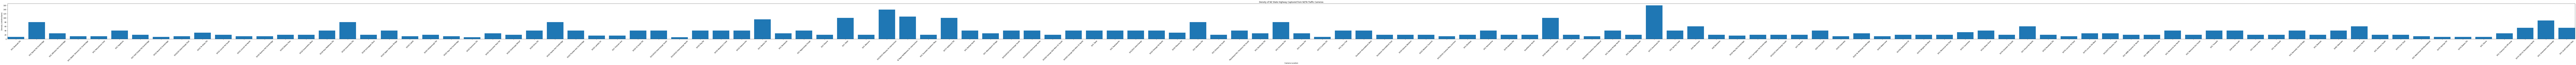

In [ ]:
# create a bar chart with camera numbers and density

import matplotlib.pyplot as plt
import numpy as np

N = 129
plt.bar(cam_list, density_list)
plt.title('Density of NZ State Highway Captured from NZTA Traffic Cameras')
plt.xlabel('Camera Location')
plt.ylabel('Density (veh/km/lane)')
plt.xticks(range(N))
plt.xticks(rotation=45)
plt.gca().margins(x=0)
plt.gcf().canvas.draw()
tl = plt.gca().get_xticklabels()
maxsize = max([t.get_window_extent().width for t in tl])
m = 0.2 # inch margin
s = maxsize/plt.gcf().dpi*N+2*m
margin = m/plt.gcf().get_size_inches()[0]

plt.gcf().subplots_adjust(left=margin, right=1.-margin)
plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

plt.show

## percentage of vehicle types on NZ highways

In [8]:
import pandas as pd
import os

directory = "/content/drive/MyDrive/Colab Notebooks/yolov5/runs/detect/detect_1/labels/" 
colnames=['class', 'x_center', 'y_center', 'width', 'height', 'confidence']  

data = []

for file in os.listdir(directory):
  df = pd.read_csv(directory+file, sep=" ", names=colnames, header=None, engine='python')
  df.drop(df.columns[[1, 2, 3, 4, 5]], axis=1, inplace=True)
  df["class"].replace({0: "bus", 1: "car", 2: "motorbike", 3: "truck", 4: "van"}, inplace=True)
  veh_type = df['class'].value_counts().rename_axis('vehicle_type').to_frame('counts')
  records = veh_type.to_records()
  result=list(records)
  data.append(result)

def flatten(t):
    return [item for sublist in t for item in sublist]

vehicle_list = flatten(data) # make flat list out of a list of lists

df_veh = pd.DataFrame.from_records(vehicle_list, columns=['vehicle', 'counts'])

vehicles = ['car', 'truck', 'motorbike', 'bus', 'van']
veh_count = []

for vehicle in vehicles:
  freq = df_veh.loc[df_veh['vehicle']==vehicle]
  total = freq['counts'].sum()
  veh_count.append([vehicle, total]) # list with vehicle type and count 
  print(f'{vehicle} count is {total}')

# print(veh_count)



car count is 208
truck count is 28
motorbike count is 0
bus count is 1
van count is 6


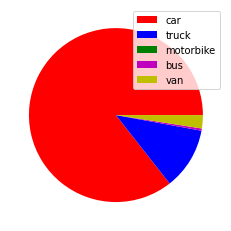

In [9]:
# make pie chart using the the vehicle count
import pandas as pd
import matplotlib.pyplot as plt


df1 = pd.DataFrame(veh_count, columns=['Vehicle_type', 'Counts'])
# print(df1)

fig, axes = plt.pie(df1['Counts'], colors = ['r', 'b', 'g', 'm', 'y'])
plt.legend(fig, vehicles, loc='best')

plt.show()

# Detection vs Accuracy Graph

In [ ]:
import pandas as pd
import os


directory_1 = "/content/drive/MyDrive/Colab Notebooks/yolov5/runs/detect/coco_v2/labels/"  # directory for COCO training set
directory_2 = "/content/drive/MyDrive/Colab Notebooks/yolov5/runs/detect/4.8k_v2/labels/" # directory for 4.8k training set
directory_3 = "/content/drive/MyDrive/Colab Notebooks/yolov5/runs/detect/4.3k_v2/labels/" # directory for 4.3k training set
directory_4 = "/content/drive/MyDrive/Colab Notebooks/yolov5/runs/detect/3.9k_v2/labels/" # directory for 3.9k training set
directory_5 = "/content/drive/MyDrive/Colab Notebooks/yolov5/runs/detect/1.6k_no_aug_v2/labels/" # directory for 1.6k (no augmentation) training set
directory_6 = "/content/drive/MyDrive/Colab Notebooks/yolov5/runs/detect/2.5k_v2/labels/" # directory for 2.5k training set
directory_7 = "/content/drive/MyDrive/Colab Notebooks/yolov5/runs/detect/2k_v2/labels/" # directory for 2k training set

# find the total number of detections
def conf_detect(directory):
  colnames=['class', 'x_center', 'y_center', 'width', 'height', 'confidence']
  count = []
  conf = []

  for file in os.listdir(directory):
    df = pd.read_csv(directory+file, sep=" ", names=colnames, header=None, engine='python')
    df.drop(df.columns[[1, 2, 3, 4]], axis=1, inplace=True)
    detect_count = len(df.index) # find the total number of detections
    count.append(detect_count)
    total_conf = df['confidence'].sum() # find the average confidence
    mean_conf = total_conf / len(df.index)
    conf.append(mean_conf)

  avg_conf = sum(conf) / len(conf)
  total_detect = sum(count)

  return([avg_conf, total_detect])

[avg_conf_1, total_detect_1] = conf_detect(directory_1)
[avg_conf_2, total_detect_2] = conf_detect(directory_2)
[avg_conf_3, total_detect_3] = conf_detect(directory_3)
[avg_conf_4, total_detect_4] = conf_detect(directory_4)
[avg_conf_5, total_detect_5] = conf_detect(directory_5)
[avg_conf_6, total_detect_6] = conf_detect(directory_6)
[avg_conf_7, total_detect_7] = conf_detect(directory_7)


In [ ]:
import pandas as pd

# at conf 0.5
data = [['COCO training set', total_detect_1, avg_conf_1], 
        ['4.8k training set', total_detect_2, avg_conf_2], 
        ['4.3k training set', total_detect_3, avg_conf_3],
        ['3.9k training set', total_detect_4, avg_conf_4], 
        ['1.6k (no augmentation) training set', total_detect_5, avg_conf_5],
        ['2.5k training set', total_detect_6, avg_conf_6],
        ['2k training set', total_detect_7, avg_conf_7]]
df = pd.DataFrame(data, columns = ['Training_Set', 'Total_Detection', 'Average_Confidence'])
df

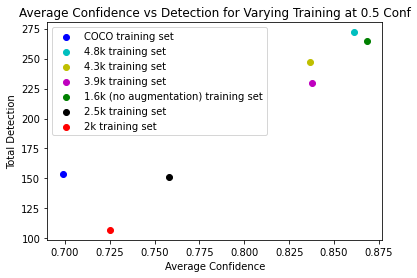

In [ ]:
# graph results of accuracy vs detection
import matplotlib.pyplot as plt
import pandas as pd

coco = plt.scatter(df.Average_Confidence[0], df.Total_Detection[0], marker='o', color='b')
ts_1 = plt.scatter(df.Average_Confidence[1], df.Total_Detection[1], marker='o', color='c')
ts_2 = plt.scatter(df.Average_Confidence[2], df.Total_Detection[2], marker='o', color='y')
ts_3 = plt.scatter(df.Average_Confidence[3], df.Total_Detection[3], marker='o', color='m')
ts_4 = plt.scatter(df.Average_Confidence[4], df.Total_Detection[4], marker='o', color='g')
ts_5 = plt.scatter(df.Average_Confidence[5], df.Total_Detection[5], marker='o', color='k')
ts_6 = plt.scatter(df.Average_Confidence[6], df.Total_Detection[6], marker='o', color='r')

plt.legend((coco, ts_1, ts_2, ts_3, ts_4, ts_5, ts_6), 
           ('COCO training set', '4.8k training set', '4.3k training set', '3.9k training set',
            '1.6k (no augmentation) training set', '2.5k training set', '2k training set'),
           scatterpoints=1, fontsize=10)
plt.xlabel('Average Confidence')
plt.ylabel('Total Detection')
plt.title('Average Confidence vs Detection for Varying Training at 0.5 Conf')

plt.show()



# Export Processed Data To Spreadsheet

In [20]:
import pandas as pd
import os

directory = "/content/drive/MyDrive/Colab Notebooks/yolov5/runs/detect/detect_1/labels/"  # change directory
colnames=['vehicle', 'x_center', 'y_center', 'width', 'height', 'confidence']

car_list = []
truck_list = []
bus_list = []
van_list = []
motorbike_list = []

for file in os.listdir(directory):
  df = pd.read_csv(directory+file, sep=" ", names=colnames, header=None, engine='python')
  df.drop(df.columns[[1, 2, 3, 4, 5]], axis=1, inplace=True)
  df["vehicle"].replace({0: "bus", 1: "car", 2: "motorbike", 3: "truck", 4: "van"}, inplace=True)
  car = df[df.vehicle == 'car'].shape[0]
  truck = df[df.vehicle == 'truck'].shape[0]
  bus = df[df.vehicle == 'bus'].shape[0]
  van = df[df.vehicle == 'van'].shape[0]
  motorbike = df[df.vehicle == 'motorbike'].shape[0]

  car_list.append(car)
  truck_list.append(truck)
  bus_list.append(bus)
  motorbike_list.append(motorbike)
  van_list.append(van)


In [21]:
import pandas as pd
import os

directory = "/content/drive/MyDrive/Colab Notebooks/yolov5/runs/detect/detect_1/labels/"  # change directory

remove_if_not = []  # remove the timestamp for cctv that are unavailable or at intersection

for file in os.listdir(directory):
  file = file[1:-6]
  remove_if_not.append(file)

remove_if_not = [item.replace(item, '_'+item+'_') for item in remove_if_not]
remove_if_not = [item.replace('_20_', '/20_') for item in remove_if_not]
remove_if_not = [item.replace('_30_', '/30_') for item in remove_if_not]
remove_if_not = [item.replace('_40_', '/40_') for item in remove_if_not]
remove_if_not = [item.replace('_50_', '/50_') for item in remove_if_not]
remove_if_not = [item.replace('_60_', '/60_') for item in remove_if_not]
remove_if_not = [item.replace('_70_', '/70_') for item in remove_if_not]
remove_if_not = [item.replace('_80_', '/80_') for item in remove_if_not]
remove_if_not = [item.replace('_90_', '/90_') for item in remove_if_not]

timestamp1 = [x for x in timestamp if x[-5:] in remove_if_not]
timestamp2 = [x for x in timestamp if x[-4:] in remove_if_not]
 
timestamp3 = timestamp1 + timestamp2
timestamp3 = [x[:-5] for x in timestamp3]

sorted_time = sorted(timestamp3)

In [22]:
data = {'Location':cam_list, 'Timestamp':sorted_time, 'Car':car_list, 'Van':van_list, 'Truck':truck_list, 'Bus':bus_list, 'Motorbike':motorbike_list, 'Density':density_list}

if len(sorted_time) == len(cam_list):
  df = pd.DataFrame(data)
  print("dataframe is made")
else:
  print(f'camera list: {len(cam_list)}, timestamp list: {len(sorted_time)}. Unable to make dataframe')

dataframe is made


In [23]:
# Export dataframe to excel

filename = 'Processed_Data_SRS_2.xlsx'

df.to_excel(filename, index=False)
print('DataFrame is written to Excel File successfully.')

DataFrame is written to Excel File successfully.
